# Baseline Model

## Table of Contents
1. [Model Choice](#model-choice)
2. [Feature Selection](#feature-selection)
3. [Implementation](#implementation)
4. [Evaluation](#evaluation)


In [32]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error


## Model Choice

As a baseline modell a simple regression modell is mostly a good starting point. A appropriate modell for a classification problem is logistic regression, which I will use in the following.

## Feature Selection
The features will be the different activities. The train dataset will be based on the first 7 people in the datset whereas the test dataset will be the last of the 8 different people who gathered data. 

In [33]:
from sklearn.preprocessing import LabelEncoder

# Load the dataset
df = pd.read_csv('/home/tomruge/Schreibtisch/UNI/Semester_7/machine_learning_with_tensorflow/archive_physical_activity.csv', engine='pyarrow')

# apply undersampling. sample down to size of smallest class
df = df.groupby('activityID').apply(lambda x: x.sample(df['activityID'].value_counts().min())).reset_index(drop=True)

# Drop all rows with NaN values
df.dropna(inplace=True)

# Mask for train and test split
mask = (df['PeopleId'] == 8)

# Use LabelEncoder to automatically assign numerical values to classes
label_encoder = LabelEncoder()
df['activityID'] = label_encoder.fit_transform(df['activityID'])

# Print the mapping of original class labels to numerical labels
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

y_train = df['activityID'][~mask]
X_train = df.drop(['activityID'], axis=1)[~mask]

y_test = df['activityID'][mask]
X_test = df.drop(['activityID'], axis=1)[mask]

Label Mapping: {'Nordic walking': 0, 'ascending stairs': 1, 'cycling': 2, 'descending stairs': 3, 'ironing': 4, 'lying': 5, 'rope jumping': 6, 'running': 7, 'sitting': 8, 'standing': 9, 'transient activities': 10, 'vacuum cleaning': 11, 'walking': 12}


## Implementation

Logistic regression:


In [35]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the logistic regression model
model = LogisticRegression(multi_class='multinomial', max_iter=100000)
model.fit(X_train_scaled, y_train)


LogisticRegression(max_iter=100000, multi_class='multinomial')

## Evaluation

My used metrics will be: $$ Accuracy = \frac{Number\ of\ Correct\ Predictions}{Total\ Number\ of\ Predictions}$$


In [37]:
# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Use LabelEncoder to convert numerical predictions back to categorical labels
label_encoder = LabelEncoder()
label_encoder.fit(df['activityID'])
y_pred_labels = label_encoder.inverse_transform(y_pred)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_labels)
print('Mapping:', label_mapping)
print(f'Accuracy: {accuracy:.2f}')

# Display classification report
print(classification_report(y_test, y_pred_labels))


Mapping: {'Nordic walking': 0, 'ascending stairs': 1, 'cycling': 2, 'descending stairs': 3, 'ironing': 4, 'lying': 5, 'rope jumping': 6, 'running': 7, 'sitting': 8, 'standing': 9, 'transient activities': 10, 'vacuum cleaning': 11, 'walking': 12}
Accuracy: 0.41
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6678
           1       0.29      0.58      0.38      4321
           2       0.62      0.93      0.74      6743
           3       0.16      0.38      0.22      4045
           4       0.00      0.00      0.00      5883
           5       1.00      0.94      0.97      5329
           6       0.71      0.64      0.68      8806
           7       0.45      0.53      0.48      7270
           8       0.05      0.00      0.00      5252
           9       0.01      0.00      0.00      5673
          10       0.15      0.20      0.18      6750
          11       0.30      0.39      0.34      5981
          12       0.42      0.60   

Confusion matrix:

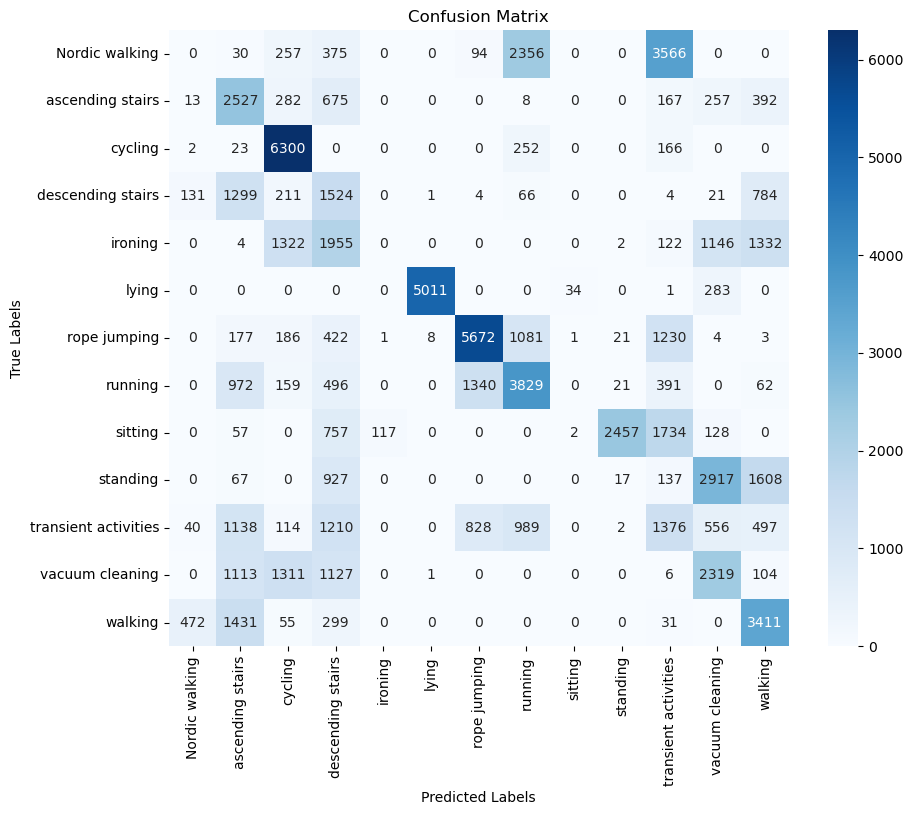

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


As expected the modell is confused by transient activities, since they are not well defined and have a big deviation within itself. Also activities which can be seen related like sitting and lying got confused very often. But for a first modell not that bad.